In [3]:
#import api
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from forex_python.converter import CurrencyRates
from forex_python.bitcoin import BtcConverter

### 1) TIDY

In [14]:
datum = '04.10.2017'
dan = int(datum[:2])
mesec = int(datum[3:5])
leto = int(datum[6:])
dan
#mesec
#leto

4

In [16]:
def preprocessing(df, datum):
    dan = int(datum[:2])
    mesec = int(datum[3:5])
    leto = int(datum[6:])
    c = CurrencyRates()
    date_obj = datetime.datetime(leto, mesec, dan)
    eur_rate = c.get_rates('USD', date_obj)['EUR']
    b = BtcConverter()
    btc_rate = b.get_previous_price('USD', date_obj)
    pd.options.mode.chained_assignment = None  # default='warn'
    df = df.drop(df.columns[[0, 1]], axis=1)
    # priredim še enotni stolpec cen, kjer bodo vse cene v dolarjih 
    df['ceneDolarji'] = 0
    df['ceneDolarji'][df['druga'] == 'USD'] = df['price']
    df['ceneDolarji'][df['druga'] == 'EUR'] = df['price'] / eur_rate 
    df['ceneDolarji'][df['druga'] == 'BTC'] = df['price'] * btc_rate
    df['Leva'] = np.where(df['type']==0, df['druga'], df['prva'])
    df['Desna'] = np.where(df['type']==0, df['prva'], df['druga'])
    df['combo'] = df['Leva'] + df['Desna']
    df = df.drop(df.columns[[2, 3, 4]], axis=1)
    df['volume'] = df['ceneDolarji'] * df['amount']
    return df

In [6]:
def last(df):
    df_combo = df.groupby('combo')
    tmp = pd.DataFrame(df_combo.sum()['volume'])
    tmp.index.name = None
    tmp['combo'] = tmp.index
    tmp2 = pd.DataFrame(df_combo.sum()['amount'])
    tmp2.index.name = None
    tmp2['combo'] = tmp2.index
    tmp3 = pd.DataFrame(df_combo.mean()['ceneDolarji'])
    tmp3.index.name = None
    tmp3['combo'] = tmp3.index
    tmp4 = pd.DataFrame(df_combo.count()['price'])
    tmp4.index.name = None
    tmp4['combo'] = tmp4.index
    final = pd.merge(tmp, tmp2, on='combo')
    final = pd.merge(final, tmp3, on='combo')
    final = pd.merge(final, tmp4, on='combo')
    final.columns = ['volume', 'combo', 'nr_tokens', 'priceUSD', 'nr_txs']
    final['prva'] = final['combo'].str.extract('(^...)', expand=True)
    final['druga'] = final['combo'].str.extract('(...$)', expand=True)
    return final

In [7]:
def pametno_preberi(datum):
    pari = ['btcusd', 'btceur', 'eurusd', 'xrpusd', 'xrpeur', 'xrpbtc', 'ltcusd', 'ltceur', 'ltcbtc', 'ethusd', 'etheur', 'ethbtc']
    df = pd.DataFrame()
    for par in pari:
        ime = datum + '/' + par + '.csv'
        data = pd.read_csv(ime)
        data['prva'] = par[:3].upper()
        data['druga'] = par[3:].upper()
        df = df.append(data)
    return df

In [8]:
def tidy(datum):
    df = pametno_preberi(datum)
    df = preprocessing(df, datum)
    final = last(df)
    return final

In [6]:
for i in range(13,24):
    datum = str(i) + '.09.2017'
    df = tidy(datum)
    ime = datum + '/tidy.csv'
    df.to_csv(ime, index=False)
    print(datum + ' tidy ima!')

21.09.2017 tidy ima!
22.09.2017 tidy ima!
23.09.2017 tidy ima!


In [17]:
for i in range(31,37):
    if i <= 30:
        datum = str(i) + '.09.2017'
    else:
        datum = '0' + str(i - 30) + '.10.2017'
    df = tidy(datum)
    ime = datum + '/tidy.csv'
    df.to_csv(ime, index=False)
    print(datum + ' tidy ima!')

01.10.2017 tidy ima!
02.10.2017 tidy ima!
03.10.2017 tidy ima!
04.10.2017 tidy ima!
05.10.2017 tidy ima!
06.10.2017 tidy ima!


### 2) DAILY SNAPSHOT

In [23]:
#volume in USD
datum = str(13) + '.09.2017'
ime = datum + '/tidy.csv'
df = pd.read_csv(ime)
df = df[df.columns[:2]]
df.columns = [datum, 'combo']
tabela = df

for i in range(14,37):
    if i <= 30:
        datum = str(i) + '.09.2017'
    else:
        datum = '0' + str(i - 30) + '.10.2017'
    ime = datum + '/tidy.csv'
    df = pd.read_csv(ime)
    df = df[df.columns[:2]]
    df.columns = [datum, 'combo']
    tabela = pd.merge(tabela, df, how='inner', on='combo')
tabela = tabela.set_index('combo')
tabela = tabela.transpose()
tabela['Total'] = tabela.sum(axis=1)
tabela.loc['Mean$volume'] = tabela.mean()
tabela = tabela.astype(int)
tabela

combo,BTCETH,BTCEUR,BTCLTC,BTCUSD,BTCXRP,ETHBTC,ETHEUR,ETHUSD,EURBTC,EURETH,...,LTCUSD,USDBTC,USDETH,USDEUR,USDLTC,USDXRP,XRPBTC,XRPEUR,XRPUSD,Total
13.09.2017,772924,12516633,259549,64435284,363283,1070001,4220521,6061941,10359445,6545613,...,3618493,51139769,7389151,1280530,3477036,1545867,313249,1130390,1849708,183029939
14.09.2017,1804145,12673283,665822,78623606,474212,1971037,5635807,9156655,10699317,5001854,...,9026656,67452577,8177195,1019587,4159122,2282303,261836,1553788,3239545,232684600
15.09.2017,3041929,18215086,2088408,98621206,600383,3637077,8943860,10215108,22115964,8433275,...,11228190,104536798,12404098,2444850,7964276,4386634,759192,2115255,3839494,340099914
16.09.2017,1609841,4361773,672793,42083185,240190,1840576,2050914,3464411,3584049,1720902,...,2180404,43033071,4595378,736789,2182358,776336,227228,385640,1047401,119675752
17.09.2017,1074755,2979833,284915,21086552,231004,1110545,1872154,1818951,3091943,1267375,...,886741,21341294,3084229,588659,923308,955389,276758,254331,712494,65842754
18.09.2017,1785107,6587974,208633,29745156,277314,2482569,3266118,5204078,6147027,6638912,...,2419164,38244808,8472685,1389293,2226333,1236635,414861,523984,1548601,122147669
19.09.2017,932031,3242022,364077,32531359,145260,1011310,2227101,3661199,4311582,3381028,...,2825860,27877497,3174282,802769,2042301,828113,170925,408785,956858,93848216
20.09.2017,516776,4631479,124440,25044223,128122,609611,1303690,2211292,4897360,3437877,...,1875301,20808290,2678989,498208,1063428,560762,140566,348805,819566,73458013
21.09.2017,1239398,4845215,196240,36441964,320591,1034791,2237624,4841666,4227385,2856820,...,1826781,30546331,3098282,529227,1403400,1035951,474249,511692,1166261,101163409
22.09.2017,747749,2947223,148837,25926161,192627,692592,2006109,2003731,4945775,1898796,...,2085600,28353906,2951037,585384,1948261,579050,176272,411844,827428,82398908


In [72]:
tabela['Total'].std()

66388380.727571875

In [30]:
tabela = tabela.transpose()
resultVolume = tabela.sort_values(['Mean$volume'], ascending=[0])
resultVolume

,13.09.2017,14.09.2017,15.09.2017,16.09.2017,17.09.2017,18.09.2017,19.09.2017,20.09.2017,21.09.2017,22.09.2017,...,28.09.2017,29.09.2017,30.09.2017,01.10.2017,02.10.2017,03.10.2017,04.10.2017,05.10.2017,06.10.2017,Mean$volume
combo,,,,,,,,,,,,,,,,,,,,,
USDBTC,51139769,67452577,104536798,43033071,21341294,38244808,27877497,20808290,30546331,28353906,...,19499665,25089951,18592627,16043949,20452246,29841174,19093135,21611954,18643787,30545023
BTCUSD,64435284,78623606,98621206,42083185,21086552,29745156,32531359,25044223,36441964,25926161,...,20820494,25245239,13506928,14821711,15833004,23799373,16872766,14310893,17898201,30270412
EURBTC,10359445,10699317,22115964,3584049,3091943,6147027,4311582,4897360,4227385,4945775,...,6644282,4951610,2904226,2894128,3642838,3555136,3114071,4351199,2715897,5301322
BTCEUR,12516633,12673283,18215086,4361773,2979833,6587974,3242022,4631479,4845215,2947223,...,4448775,2899255,1993053,2220007,3144879,4055219,2310152,4642437,3196052,5141595
USDETH,7389151,8177195,12404098,4595378,3084229,8472685,3174282,2678989,3098282,2951037,...,2684969,4278824,1826152,1355098,2083414,1513844,728329,1214899,2087406,3832895
EURETH,6545613,5001854,8433275,1720902,1267375,6638912,3381028,3437877,2856820,1898796,...,3006281,2168056,1657259,983206,2006137,1669211,832666,3667200,2292034,3470537
ETHUSD,6061941,9156655,10215108,3464411,1818951,5204078,3661199,2211292,4841666,2003731,...,2714188,3457494,1768056,1273960,1602053,1329602,751324,1379214,1328500,3174723
ETHEUR,4220521,5635807,8943860,2050914,1872154,3266118,2227101,1303690,2237624,2006109,...,1899146,2356807,1107329,664511,593098,796908,541232,952302,766578,2095580
LTCUSD,3618493,9026656,11228190,2180404,886741,2419164,2825860,1875301,1826781,2085600,...,1183431,1577883,454129,649104,338287,548651,539694,609353,346287,2077293


In [106]:
resultVolume2 = resultVolume[resultVolume['Mean$volume'] > 3000000]
resultVolume2 = resultVolume2[['Mean$volume']]
resultVolume2

,Mean$volume
combo,
USDBTC,30545023
BTCUSD,30270412
EURBTC,5301322
BTCEUR,5141595
USDETH,3832895
EURETH,3470537
ETHUSD,3174723


In [107]:
resultVolume1 = resultVolume[resultVolume['Mean$volume'] < 3000000]
resultVolume1 = resultVolume1[['Mean$volume']]
resultVolume1['Mean$volume'].sum()

15547637

In [108]:
resultVolume2.loc['other'] = [15547637]
resultVolume2

,Mean$volume
combo,
USDBTC,30545023
BTCUSD,30270412
EURBTC,5301322
BTCEUR,5141595
USDETH,3832895
EURETH,3470537
ETHUSD,3174723
other,15547637


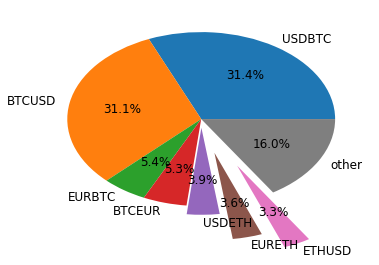

In [125]:
explode = (0, 0, 0, 0, 0.1, 0.4, 0.6, 0)
%matplotlib inline
resultVolume2['Mean$volume'].plot.pie(autopct='%1.1f%%', fontsize=12, explode=explode)
plt.ylabel('')
plt.figure(figsize=(100,50))

{'boxes': [<matplotlib.lines.Line2D at 0xb64fc18>],
 'caps': [<matplotlib.lines.Line2D at 0xb6b4940>,
 'fliers': [<matplotlib.lines.Line2D at 0xb6c29e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xb6c2470>],
 'whiskers': [<matplotlib.lines.Line2D at 0xb64fd68>,
  <matplotlib.lines.Line2D at 0xb6b43c8>]}

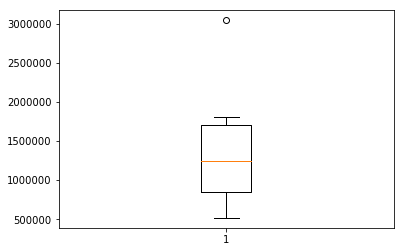

In [12]:
%matplotlib inline
plt.boxplot(tabela['BTCETH'])

In [58]:
filter_col = [col for col in tabela if (col.startswith('EUR') or col.startswith('USD')) and col != 'EURUSD' and col != 'USDEUR']
filter_col 

['EURBTC',
 'EURETH',
 'EURLTC',
 'EURXRP',
 'USDBTC',
 'USDETH',
 'USDLTC',
 'USDXRP']

In [59]:
filter_col2 = [col for col in tabela if ((col[3:]=='EUR') or (col[3:]=='USD')) and col != 'USDEUR' and col != 'EURUSD']
filter_col2

['BTCEUR',
 'BTCUSD',
 'ETHEUR',
 'ETHUSD',
 'LTCEUR',
 'LTCUSD',
 'XRPEUR',
 'XRPUSD']

In [61]:
filter_col3 = [col for col in tabela if (col not in filter_col2) and (col not in filter_col) and col != 'USDEUR' and col != 'EURUSD']
filter_col3

['BTCETH', 'BTCLTC', 'BTCXRP', 'ETHBTC', 'LTCBTC', 'XRPBTC']

In [69]:
# CC to CC
tabela1 = tabela[filter_col3]
tabela1 = tabela1.astype(int)
tabela1 = tabela1.transpose()
#tabela = tabela[['meanVolume']]
tabela1.loc['Total']= tabela1.sum()
#resultVolume = tabela.sort_values(['meanVolume'], ascending=[0])
#tabela['mean'] = tabela.mean(axis=1)
tabela1

,13.09.2017,14.09.2017,15.09.2017,16.09.2017,17.09.2017,18.09.2017,19.09.2017,20.09.2017,21.09.2017,22.09.2017,...,28.09.2017,29.09.2017,30.09.2017,01.10.2017,02.10.2017,03.10.2017,04.10.2017,05.10.2017,06.10.2017,Mean$volume
combo,,,,,,,,,,,,,,,,,,,,,
BTCETH,772924,1804145,3041929,1609841,1074755,1785107,932031,516776,1239398,747749,...,879755,875830,580569,345268,750913,499018,336443,455725,537277,975934
BTCLTC,259549,665822,2088408,672793,284915,208633,364077,124440,196240,148837,...,113781,207408,97122,123053,140785,123735,124116,289950,148924,306286
BTCXRP,363283,474212,600383,240190,231004,277314,145260,128122,320591,192627,...,314728,296825,122070,181829,222686,297961,524541,1197112,353520,314734
ETHBTC,1070001,1971037,3637077,1840576,1110545,2482569,1011310,609611,1034791,692592,...,916053,1085862,494613,335631,663630,490580,421588,511477,210525,1149938
LTCBTC,355634,2835357,2113914,438759,207121,322506,333890,155090,212947,444281,...,83990,169468,75041,180976,204993,187526,159710,274841,41452,386332
XRPBTC,313249,261836,759192,227228,276758,414861,170925,140566,474249,176272,...,452919,222809,157274,133689,181307,181463,569322,1040697,406358,311322
Total,3134640,8012409,12240903,5029387,3185098,5490990,2957493,1674605,3478216,2402358,...,2761226,2858202,1526689,1300446,2164314,1780283,2135720,3769802,1698056,3444546


In [70]:
tabela1 = tabela1.transpose()
#tabela3
tabela1['Total'].std()

2346109.9205992566

In [67]:
#CC to fiat

tabela2 = tabela[filter_col2]
tabela2 = tabela2.astype(int)
tabela2 = tabela2.transpose()
#tabela = tabela[['meanVolume']]
tabela2.loc['Total']= tabela2.sum()
#resultVolume = tabela.sort_values(['meanVolume'], ascending=[0])
#tabela['mean'] = tabela.mean(axis=1)
tabela2

,13.09.2017,14.09.2017,15.09.2017,16.09.2017,17.09.2017,18.09.2017,19.09.2017,20.09.2017,21.09.2017,22.09.2017,...,28.09.2017,29.09.2017,30.09.2017,01.10.2017,02.10.2017,03.10.2017,04.10.2017,05.10.2017,06.10.2017,Mean$volume
combo,,,,,,,,,,,,,,,,,,,,,
BTCEUR,12516633,12673283,18215086,4361773,2979833,6587974,3242022,4631479,4845215,2947223,...,4448775,2899255,1993053,2220007,3144879,4055219,2310152,4642437,3196052,5141595
BTCUSD,64435284,78623606,98621206,42083185,21086552,29745156,32531359,25044223,36441964,25926161,...,20820494,25245239,13506928,14821711,15833004,23799373,16872766,14310893,17898201,30270412
ETHEUR,4220521,5635807,8943860,2050914,1872154,3266118,2227101,1303690,2237624,2006109,...,1899146,2356807,1107329,664511,593098,796908,541232,952302,766578,2095580
ETHUSD,6061941,9156655,10215108,3464411,1818951,5204078,3661199,2211292,4841666,2003731,...,2714188,3457494,1768056,1273960,1602053,1329602,751324,1379214,1328500,3174723
LTCEUR,1440018,1881913,3951617,614172,554795,831400,962591,349336,738342,721003,...,508181,532606,156315,344970,217015,277810,219609,414654,238542,698138
LTCUSD,3618493,9026656,11228190,2180404,886741,2419164,2825860,1875301,1826781,2085600,...,1183431,1577883,454129,649104,338287,548651,539694,609353,346287,2077293
XRPEUR,1130390,1553788,2115255,385640,254331,523984,408785,348805,511692,411844,...,674415,566400,244278,157457,339694,272402,487914,1043025,608001,570497
XRPUSD,1849708,3239545,3839494,1047401,712494,1548601,956858,819566,1166261,827428,...,1391924,1317997,1187354,686034,792382,876927,1315175,2510140,1562767,1394196
Total,95272988,121791253,157129816,56187900,30165851,50126475,46815775,36583692,52609545,36929099,...,33640554,37953681,20417442,20817754,22860412,31956892,23037866,25862018,25944928,45422434


In [68]:
tabela2 = tabela2.transpose()
#tabela3
tabela2['Total'].std()

32873333.080827195

In [63]:
# fiat to CC

tabela3 = tabela[filter_col]
tabela3 = tabela3.astype(int)
tabela3 = tabela3.transpose()
#tabela = tabela[['meanVolume']]
tabela3.loc['Total']= tabela3.sum()
#resultVolume = tabela.sort_values(['meanVolume'], ascending=[0])
#tabela3['mean'] = tabela3.mean(axis=1)
tabela3

,13.09.2017,14.09.2017,15.09.2017,16.09.2017,17.09.2017,18.09.2017,19.09.2017,20.09.2017,21.09.2017,22.09.2017,...,28.09.2017,29.09.2017,30.09.2017,01.10.2017,02.10.2017,03.10.2017,04.10.2017,05.10.2017,06.10.2017,Mean$volume
combo,,,,,,,,,,,,,,,,,,,,,
EURBTC,10359445,10699317,22115964,3584049,3091943,6147027,4311582,4897360,4227385,4945775,...,6644282,4951610,2904226,2894128,3642838,3555136,3114071,4351199,2715897,5301322
EURETH,6545613,5001854,8433275,1720902,1267375,6638912,3381028,3437877,2856820,1898796,...,3006281,2168056,1657259,983206,2006137,1669211,832666,3667200,2292034,3470537
EURLTC,1073761,1521416,3216867,556983,341781,821695,506770,371976,525544,691432,...,485165,428102,334986,173788,254681,258246,199014,265519,231351,593473
EURXRP,765521,954094,2011178,380082,339344,547839,308684,231005,264142,306133,...,623527,273097,151846,227387,373939,325508,612556,1732460,614130,528759
USDBTC,51139769,67452577,104536798,43033071,21341294,38244808,27877497,20808290,30546331,28353906,...,19499665,25089951,18592627,16043949,20452246,29841174,19093135,21611954,18643787,30545023
USDETH,7389151,8177195,12404098,4595378,3084229,8472685,3174282,2678989,3098282,2951037,...,2684969,4278824,1826152,1355098,2083414,1513844,728329,1214899,2087406,3832895
USDLTC,3477036,4159122,7964276,2182358,923308,2226333,2042301,1063428,1403400,1948261,...,908891,999130,474261,698203,419188,360459,265521,479979,248179,1541743
USDXRP,1545867,2282303,4386634,776336,955389,1236635,828113,560762,1035951,579050,...,1069524,1144622,661494,336691,693694,443777,1460801,3573063,1751690,1253388
Total,82296163,100247878,165069090,56829159,31344663,64335934,42430257,34049687,43957855,41674390,...,34922304,39333392,26602851,22712450,29926137,37967355,26306093,36896273,28584474,47067140


In [65]:
#tabela3 = tabela3.transpose()
tabela3
tabela3['Total'].std()


30832285.78548968

In [48]:
volume = tabela[['USDBTC', 'BTCUSD', 'EURBTC', 'BTCEUR', 'ETHBTC', 'BTCETH']]
volume = volume.tail(1)
volume

combo,USDBTC,BTCUSD,EURBTC,BTCEUR,ETHBTC,BTCETH
Mean$volume,30545023,30270412,5301322,5141595,1149938,975934


In [24]:
#za list nov glej spodaj
volume = tabela[nov]
volume = volume.tail(1)
volume

combo,EURUSD,USDEUR,XRPUSD,USDXRP,XRPEUR,EURXRP,XRPBTC,BTCXRP,LTCUSD,USDLTC,LTCEUR,EURLTC,LTCBTC,BTCLTC,ETHUSD,USDETH,ETHEUR,EURETH
Mean$volume,701467,648557,1394196,1253388,570497,528759,311322,314734,2077293,1541743,698138,593473,386332,306286,3174723,3832895,2095580,3470537


In [49]:
volume.iloc[0][1]

42973037.679227285

In [11]:
#nr_txs
datum = str(13) + '.09.2017'
ime = datum + '/tidy.csv'
df = pd.read_csv(ime)
df = df[['combo', 'nr_txs']]
df.columns = ['combo', datum]
tabela = df

for i in range(14,37):
    if i <= 30:
        datum = str(i) + '.09.2017'
    else:
        datum = '0' + str(i - 30) + '.10.2017'
    ime = datum + '/tidy.csv'
    df = pd.read_csv(ime)
    df = df[['combo', 'nr_txs']]
    df.columns = ['combo', datum]
    tabela = pd.merge(tabela, df, how='inner', on='combo')
tabela = tabela.set_index('combo')
tabela = tabela.transpose()
tabela.loc['Mean number of transaction'] = tabela.mean()
#tabela.loc['min'] = tabela.min()
#tabela.loc['max'] = tabela.max()
#tabela['Total'] = tabela.sum(axis=1)
tabela = tabela.astype(int)
tabela

combo,BTCETH,BTCEUR,BTCLTC,BTCUSD,BTCXRP,ETHBTC,ETHEUR,ETHUSD,EURBTC,EURETH,...,LTCEUR,LTCUSD,USDBTC,USDETH,USDEUR,USDLTC,USDXRP,XRPBTC,XRPEUR,XRPUSD
13.09.2017,1432,6855,418,15282,840,1680,5008,7772,9436,6799,...,2707,3773,15560,7694,2633,3583,2543,618,2412,2592
14.09.2017,3122,8506,1177,21554,1116,3199,6867,9604,10702,5885,...,3713,7990,21982,8696,2384,4275,3315,685,2901,4031
15.09.2017,4512,13944,2453,31402,1501,5293,11154,13339,19832,10476,...,7361,10312,37481,13996,6123,8040,6398,1585,4049,4995
16.09.2017,3012,5389,736,10823,619,3270,4756,6342,6983,4395,...,1542,2193,15785,6318,1858,2244,1470,637,867,1741
17.09.2017,2154,4381,614,6725,656,2129,4275,3990,5473,3964,...,1890,1841,10638,5480,1779,1969,1600,720,750,1033
18.09.2017,2603,5633,469,11115,657,3284,5465,7899,8432,8475,...,2003,3351,15666,11125,2441,4030,2169,825,1068,1958
19.09.2017,1435,2993,443,8842,464,1507,3720,5367,5570,4063,...,1630,3296,10977,5033,1241,2741,1776,432,901,1346
20.09.2017,886,2603,298,6753,311,943,2079,3356,3975,2881,...,634,1987,8107,4060,767,1218,962,321,523,1182
21.09.2017,1751,3452,289,8757,705,1595,3282,6216,4919,3761,...,1556,1946,10276,5176,1037,1616,1654,758,1190,1793
22.09.2017,1544,2560,291,7878,516,1312,3183,3500,5091,3493,...,1487,2004,9768,4178,1217,1861,1268,354,921,1212


In [83]:
tabela['Total'].std()

44497.33474967097

In [132]:
tabela = tabela.transpose()
resultVolume = tabela.sort_values(['Mean number of transaction'], ascending=[0])
resultVolume

,13.09.2017,14.09.2017,15.09.2017,16.09.2017,17.09.2017,18.09.2017,19.09.2017,20.09.2017,21.09.2017,22.09.2017,...,28.09.2017,29.09.2017,30.09.2017,01.10.2017,02.10.2017,03.10.2017,04.10.2017,05.10.2017,06.10.2017,Mean number of transaction
combo,,,,,,,,,,,,,,,,,,,,,
USDBTC,15560,21982,37481,15785,10638,15666,10977,8107,10276,9768,...,10643,11219,6961,6524,8977,14167,10489,8004,8213,12163
BTCUSD,15282,21554,31402,10823,6725,11115,8842,6753,8757,7878,...,6905,8084,4193,3763,4919,6274,5265,4937,5484,8997
EURBTC,9436,10702,19832,6983,5473,8432,5570,3975,4919,5091,...,5899,4914,3597,3887,4480,5005,4076,4897,3734,5964
USDETH,7694,8696,13996,6318,5480,11125,5033,4060,5176,4178,...,2972,4458,2469,1650,1749,1681,1272,2060,2689,4827
ETHUSD,7772,9604,13339,6342,3990,7899,5367,3356,6216,3500,...,3059,3672,1821,1540,1653,1457,1196,2151,1803,4286
EURETH,6799,5885,10476,4395,3964,8475,4063,2881,3761,3493,...,3941,3526,2568,1394,2080,1987,1202,3355,2988,4220
BTCEUR,6855,8506,13944,5389,4381,5633,2993,2603,3452,2560,...,3066,2596,1501,1508,2433,2982,1988,3241,2191,3921
ETHEUR,5008,6867,11154,4756,4275,5465,3720,2079,3282,3183,...,2902,3513,2021,1161,969,1138,898,1427,1109,3166
LTCUSD,3773,7990,10312,2193,1841,3351,3296,1987,1946,2004,...,1237,1337,574,601,400,562,447,622,361,2111


In [143]:
resultVolume2 = resultVolume[resultVolume['Mean number of transaction'] > 2000]
resultVolume2 = resultVolume2[['Mean number of transaction']]
resultVolume2

,Mean number of transaction
combo,
USDBTC,12163
BTCUSD,8997
EURBTC,5964
USDETH,4827
ETHUSD,4286
EURETH,4220
BTCEUR,3921
ETHEUR,3166
LTCUSD,2111


In [144]:
resultVolume1 = resultVolume[resultVolume['Mean number of transaction'] < 2000]
resultVolume1 = resultVolume1[['Mean number of transaction']]
resultVolume1['Mean number of transaction'].sum()

18706

In [145]:
resultVolume2.loc['other'] = [18706]
resultVolume2

,Mean number of transaction
combo,
USDBTC,12163
BTCUSD,8997
EURBTC,5964
USDETH,4827
ETHUSD,4286
EURETH,4220
BTCEUR,3921
ETHEUR,3166
LTCUSD,2111


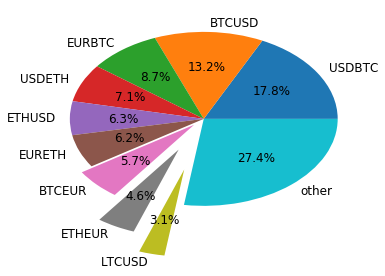

In [147]:
explode = (0, 0, 0, 0, 0, 0, 0.1, 0.4, 0.6, 0)
%matplotlib inline
resultVolume2['Mean number of transaction'].plot.pie(autopct='%1.1f%%', fontsize=12, explode=explode)
plt.ylabel('')
plt.figure(figsize=(100,50))

In [75]:
#izberem le USDBTC, BTCUSD, EURBTC, BTCEUR, ETHBTC, BTCETH
trans = tabela[['USDBTC', 'BTCUSD', 'EURBTC', 'BTCEUR', 'ETHBTC', 'BTCETH']]
trans = trans.tail(3)
trans

combo,USDBTC,BTCUSD,EURBTC,BTCEUR,ETHBTC,BTCETH
Mean number of transaction,12163,8997,5964,3921,1738,1532
min,6524,3763,2461,1343,326,403
max,37481,31402,19832,13944,5293,4512


In [22]:
pari = ['btcusd', 'btceur', 'eurusd', 'xrpusd', 'xrpeur', 'xrpbtc', 'ltcusd', 'ltceur', 'ltcbtc', 'ethusd', 'etheur', 'ethbtc']
pari = [x.upper() for x in pari]
lst = ['USDBTC', 'BTCUSD', 'EURBTC', 'BTCEUR', 'ETHBTC', 'BTCETH']
#col for col in tabela if (col not in filter_col2)
pari = [x for x in pari if (x not in lst)]
nov = []
for par in pari:
    nov_par = par[3:] + par[:3]
    nov.append(par)
    nov.append(nov_par)
    
trans2 = tabela[nov]
trans2 = trans2.tail(1)
trans2

combo,EURUSD,USDEUR,XRPUSD,USDXRP,XRPEUR,EURXRP,XRPBTC,BTCXRP,LTCUSD,USDLTC,LTCEUR,EURLTC,LTCBTC,BTCLTC,ETHUSD,USDETH,ETHEUR,EURETH
Mean number of transaction,1520,1275,1749,1869,1122,1181,550,644,2111,1799,1380,1422,490,435,4286,4827,3166,4220


In [31]:
final2 = trans2.append(volume)
final2.astype(int)
final2 = final2.transpose()
final2 = final2.sort_values('Mean$volume', ascending=0)
final2

,Mean number of transaction,Mean$volume
combo,,
USDETH,4827,3832895
EURETH,4220,3470537
ETHUSD,4286,3174723
ETHEUR,3166,2095580
LTCUSD,2111,2077293
USDLTC,1799,1541743
XRPUSD,1749,1394196
USDXRP,1869,1253388
EURUSD,1520,701467


In [24]:
final = trans.append(volume)
final.astype(int)
final

combo,USDBTC,BTCUSD,EURBTC,BTCEUR,ETHBTC,BTCETH
Mean number of transaction,15078,12249,7661,5291,2324,2164
min,8107,5618,3862,1889,943,886
max,37481,31402,19832,13944,5293,4512
Mean $ volume,41163643,42973037,6990538,6836139,1494828,1343260


In [27]:
import re

def comma_me(amount):
    orig = amount
    new = re.sub("^(-?\d+)(\d{3})", '\g<1>,\g<2>', amount)
    if orig == new:
        return new
    else:
        return comma_me(new)

final.iloc[0][0] = comma_me(str(final.iloc[0][0]))

ValueError: invalid literal for long() with base 10: '15,078'

** DELOVNA VERZIJA SPODAJ

In [65]:
tabela = tabela.astype(int)
tabela = tabela.transpose()
tabela = tabela[['mean', 'min', 'max']]
tabela.loc['Total']= tabela.sum()
result = tabela.sort_values(['mean'], ascending=[0])
result

,mean,min,max
combo,,,
Total,93517,42222,235671
USDBTC,15078,8107,37481
BTCUSD,12249,5618,31402
EURBTC,7661,3862,19832
USDETH,6911,4060,13996
ETHUSD,6391,2921,13339
BTCEUR,5291,1889,13944
EURETH,5286,2881,10476
ETHEUR,4773,2079,11154


In [23]:
tabela['mean'].sum() 

93517

In [33]:
skupno = tabela.tail(1)
skupno

,13.09.2017,14.09.2017,15.09.2017,16.09.2017,17.09.2017,18.09.2017,19.09.2017,20.09.2017,21.09.2017,22.09.2017,23.09.2017,mean,min,max
combo,,,,,,,,,,,,,,
Total,106494,143188,235035,86123,66362,105214,67922,46452,65649,58565,47785,93517,42222,235671


### 3) SIZE DISTRIBUTION

In [6]:
def size():
    pari = ['btcusd', 'btceur', 'eurusd', 'xrpusd', 'xrpeur', 'xrpbtc', 'ltcusd', 'ltceur', 'ltcbtc', 'ethusd', 'etheur', 'ethbtc']
    final = pd.DataFrame()
    for par in pari:
        tabela = pd.DataFrame()
        for i in range(13,37):
            if i <= 30:
                datum = str(i) + '.09.2017'
                ime = datum + '/' + par + '.csv'
                df = pd.read_csv(ime)
                df = df[['amount']]
                tabela = tabela.append(df)
            else:
                datum = '0' + str(i - 30) + '.10.2017'
                ime = datum + '/' + par + '.csv'
                df = pd.read_csv(ime)
                df = df[['amount']]
                tabela = tabela.append(df)
        final = final.append({'trading pair': par.upper(), 'mean transaction': round(tabela['amount'].mean(),3),
                             'Q1': round(tabela['amount'].quantile(0.25),3),
                             'Q2': round(tabela['amount'].quantile(0.5),3),
                             'Q3': round(tabela['amount'].quantile(0.75),3),
                             'Q4': round(tabela['amount'].quantile(1),3)},ignore_index=True)
    
    return final
        

{'boxes': [<matplotlib.lines.Line2D at 0xd0d9cc0>],
 'caps': [<matplotlib.lines.Line2D at 0xcb899e8>,
 'fliers': [<matplotlib.lines.Line2D at 0xcb97a90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xcb97518>],
 'whiskers': [<matplotlib.lines.Line2D at 0xd0d9e10>,
  <matplotlib.lines.Line2D at 0xcb89470>]}

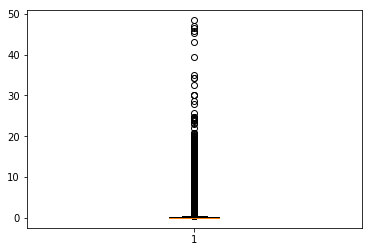

In [11]:
%matplotlib inline
plt.boxplot(tabela['amount'])

In [14]:
tabela['amount'].mean()

0.28986106982170234

In [15]:
tabela['amount'].count()

142480

In [7]:
test = size()
test = test[['trading pair', 'mean transaction', 'Q1','Q2', 'Q3','Q4']]
test

,trading pair,mean transaction,Q1,Q2,Q3,Q4
0,BTCUSD,0.753,0.021,0.115,0.700,480.000
1,BTCEUR,0.275,0.020,0.061,0.219,101.206
2,EURUSD,407.920,53.960,161.757,415.666,65806.493
3,XRPUSD,3794.655,270.000,1158.381,3500.000,498484.513
4,XRPEUR,2466.755,300.873,1006.190,2620.176,422571.178
5,XRPBTC,2637.525,380.225,1100.000,2298.835,172626.000
6,LTCUSD,18.072,1.517,5.826,18.290,3988.976
7,LTCEUR,8.947,0.900,2.935,10.000,515.092
8,LTCBTC,14.794,1.000,4.168,14.240,1124.040
9,ETHUSD,2.842,0.186,0.740,2.735,783.165


In [18]:
tabela = pd.DataFrame()
for i in range(13,37):
    if i <= 30:
        datum = str(i) + '.09.2017'
    else:
        datum = '0' + str(i - 30) + '.10.2017'
    ime = datum + '/' + 'btceur' + '.csv'
    df = pd.read_csv(ime)
    df = df[['amount']]
    tabela = tabela.append(df)

In [19]:
tabela = tabela[tabela['amount'] > 50]
len(tabela['amount'])

2

In [5]:
tabela = tabela.sort_values(['amount'], ascending=[1])
tabela.tail(10)

,amount
2836,250.000000
3211,250.000000
2627,302.326548
133,333.000000
8290,370.582893
2586,398.621174
4806,488.120766
12291,637.024889
16663,924.850465
10168,1490.253510


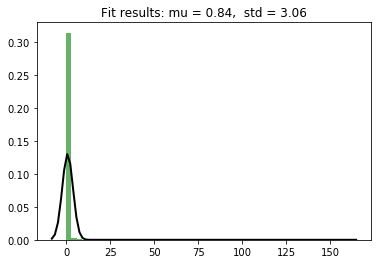

In [31]:
from scipy.stats import norm

# Generate some data for this demonstration.
tmp = tabela.values
data = np.array([x[0] for x in tmp])

# Fit a normal distribution to the data & normalize data:
mu, std = norm.fit(data)
data = [(x-mu)/std for x in data]

# Plot the histogram.
plt.hist(data, bins=50, normed=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [32]:
#data = norm.rvs(10.0, 2.5, size=500)
tmp = tabela.values
data = np.array([x[0] for x in tmp])
len(tabela)

300614

### 4) HOURLY TRAFFIC

In [20]:
def hour():
    pari = ['btcusd', 'btceur', 'eurusd', 'xrpusd', 'xrpeur', 'xrpbtc', 'ltcusd', 'ltceur', 'ltcbtc', 'ethusd', 'etheur', 'ethbtc']
    final = pd.DataFrame()
    for par in pari:
        tabela = pd.DataFrame()
        for i in range(13,37):
            if i <= 30:
                datum = str(i) + '.09.2017'
            else:
                datum = '0' + str(i - 30) + '.10.2017'
            ime = datum + '/' + par + '.csv'
            df = pd.read_csv(ime)
            df = df[['amount', 'date']]
            tabela = tabela.append(df)
        final = final.append(tabela)
    
    return final

In [21]:
len(hour())

1640851

In [23]:
k = hour()

In [24]:
k.head()

,amount,date
0,8.694229,1505347240
1,0.130000,1505347240
2,0.100000,1505347240
3,2.588700,1505347240
4,3.496500,1505347239


In [25]:
k.to_csv('tmp.csv', index=False)

In [7]:
def hour2():
    final = pd.DataFrame()
    for i in range(13,37):
        tabela = pd.DataFrame()
        if i <= 30:
            datum = str(i) + '.09.2017'
        else:
            datum = '0' + str(i - 30) + '.10.2017'
        ime = datum + '/' + 'btcusd' + '.csv'
        df = pd.read_csv(ime)
        df = df[['amount', 'date']]
        tabela = tabela.append(df)
        final = final.append(tabela)
    
    return final

In [8]:
k2 = hour2()

In [9]:
len(k2)

507863

In [10]:
k2.to_csv('btcusd.csv', index=False)